In [1]:
import pixeltable as pxt

Connected to Pixeltable database at: postgresql+psycopg://postgres:@127.0.0.1:57681/pixeltable


titulo,autor,portada
1984,George Orwell,
Constitución Argentina,Juan Bautista Alberdi,

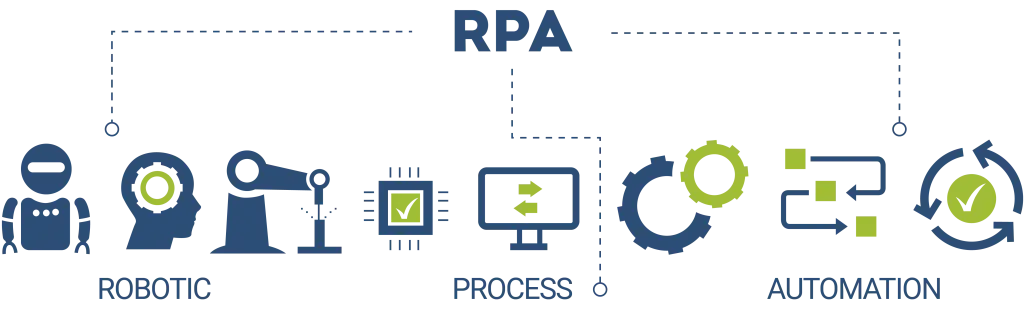
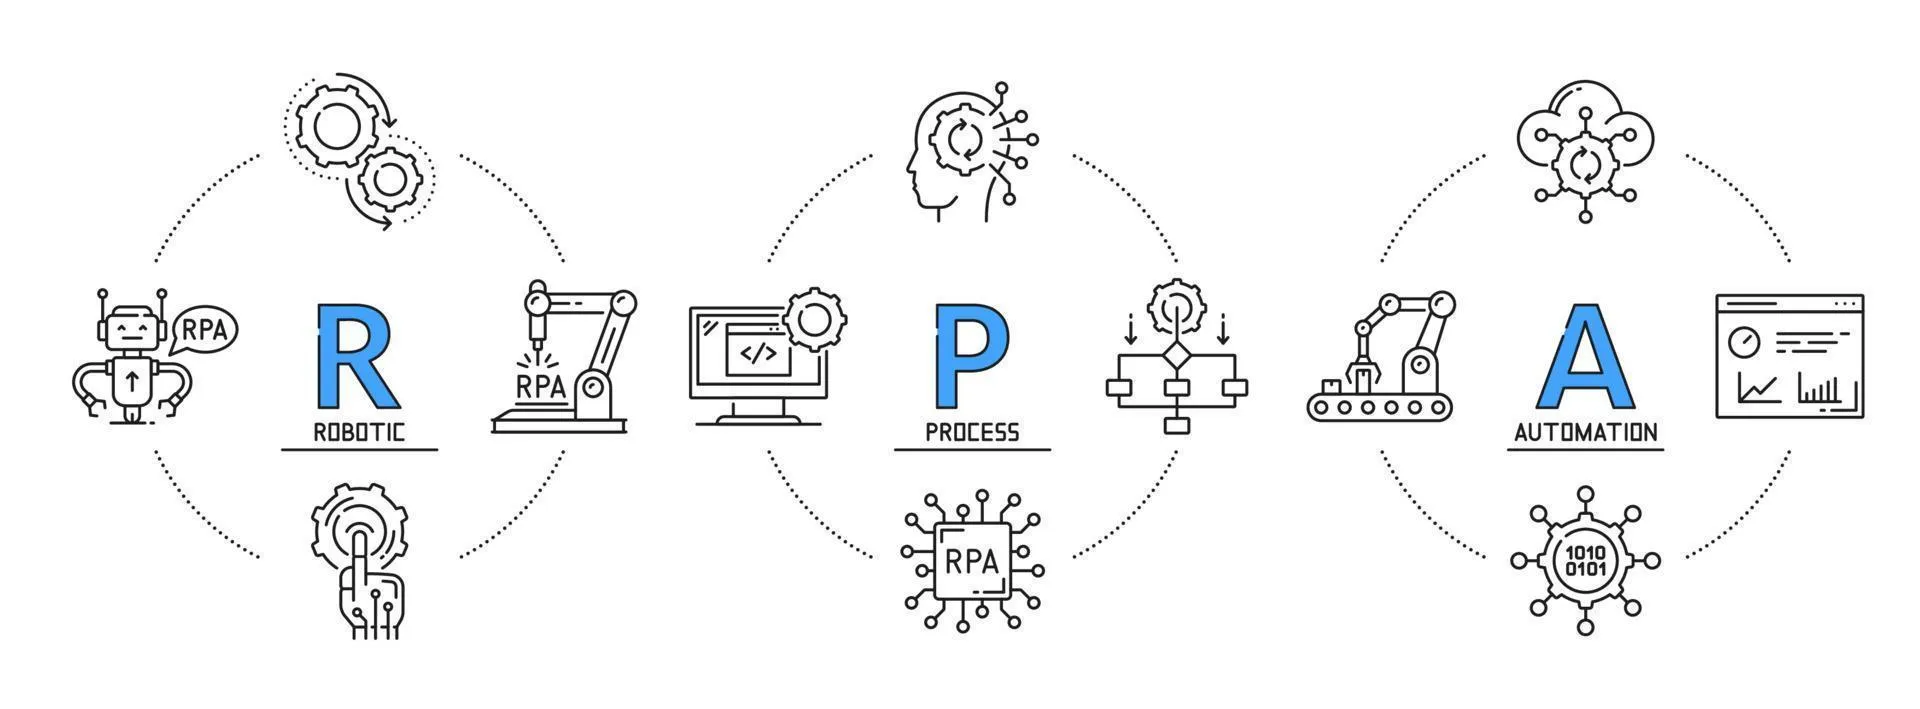

In [2]:
libros = pxt.get_table('libros')

pxt.list_tables()
libros.collect()

In [3]:
docs = pxt.create_table('docs', {
    'filename': pxt.String,
    'content': pxt.Document
})

Created table 'docs'.


In [5]:
docs.insert([
    {'filename': 'codigo_penal_juvenil_libro_1', 'content': 'docs/codigo_penal_juvenil_libro_1.pdf'},
    {'filename': 'codigo_penal_libro_1', 'content': 'docs/codigo_penal_libro_1.pdf'}
])

Inserting rows into `docs`: 2 rows [00:00, 11.87 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 6 values computed.

filename,content
codigo_penal_juvenil_libro_1,
codigo_penal_libro_1,

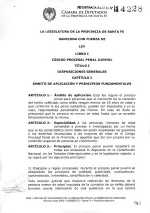
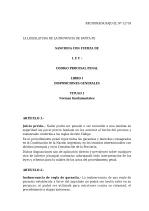

In [4]:
docs = pxt.get_table('docs')
docs.collect()

In [5]:
from pixeltable.iterators import DocumentSplitter

In [16]:
chunks_v = pxt.create_view(
    'docs_chunks',
    docs,
    iterator=DocumentSplitter.create(
        document=docs.content,
        separators='paragraph, token_limit',
        limit=350,
        metadata='page'
    )
)

Error: Path 'docs_chunks' is an existing view

pos,text,page,filename,content
511,198312023 -40 AÑOS DE DEMOCRACIA*,38,codigo_penal_juvenil_libro_1,

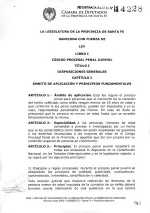

In [30]:
docs_chunks = pxt.get_table('docs_chunks')

docs_chunks.where(docs_chunks.filename == 'codigo_penal_juvenil_libro_1').order_by(docs_chunks.pos,asc=False).limit(1).collect()

In [31]:
from pixeltable.functions.huggingface import clip

In [35]:
docs_chunks.add_embedding_index(
    'text',
    embedding=clip.using(model_id='openai/clip-vit-base-patch32')
)

config.json: 0.00B [00:00, ?B/s]

c:\Users\matis\OneDrive\estudio\machine_learning\proyects\pixeltable\env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\matis\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is n

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [58]:
@pxt.query
def _get_top_chunks(query_text: str, kSize: int = 10):
    sim = docs_chunks.text.similarity(query_text)
    return (docs_chunks.order_by(sim, asc=False).limit(kSize).select(docs_chunks.page,docs_chunks.text,sim)
    )

In [67]:
sim = docs_chunks.text.similarity('Como se notifica al querellante')
res = docs_chunks.order_by(sim, asc=False).limit(10).select(docs_chunks.filename, docs_chunks.page,docs_chunks.text,sim).collect()

# Mostrar resultados
print(res)

                       filename  page                                                                              text  similarity
0          codigo_penal_libro_1   103   1)      cuando el procedimiento se paralizara durante un mes y el querellante\n    0.965024
1          codigo_penal_libro_1    94                                                  esté atento a lo que va a oír.\n    0.960566
2          codigo_penal_libro_1    15                   1)      cuando a una persona se le imputara más de un delito;\n    0.960256
3          codigo_penal_libro_1    24                     Pasado ese momento, la instancia se rechazará, sin recurso.\n    0.954147
4          codigo_penal_libro_1    95                  En estas oportunidades nadie le podrá hacer sugerencia alguna.\n    0.950617
5  codigo_penal_juvenil_libro_1    28                                                             !ÍENTARIO \nJTADOS \n    0.943339
6          codigo_penal_libro_1   129  2)      cuando se reconociera razón p